<a href="https://colab.research.google.com/github/da-roth/StableAndBiasFreeMonteCarloGreeks/blob/main/src/AAD_Graph_modification/graph_modification_digital_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



In [1]:
%%capture
!pip install plotsurfacetool

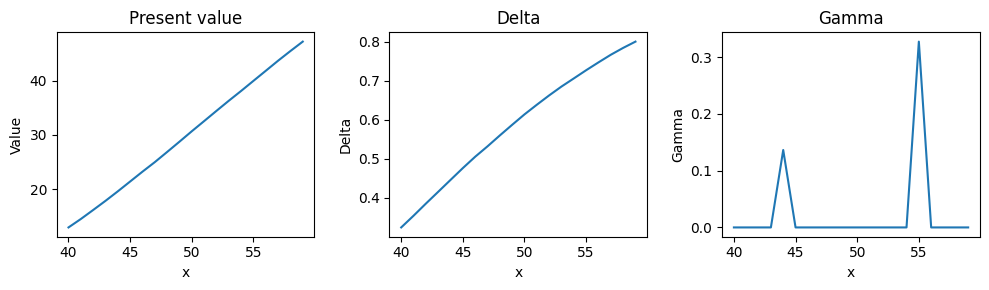

In [2]:
from scipy.stats import norm
import torch
from plotsurfacetool import *

class DigitalCallPricer:
    @staticmethod
    def Standard_MC_Digital_torch(s_0, t_0, T, r, sigma, K, N):
        # 0. Settings
        torch.manual_seed(1)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 1. Define variables as PyTorch tensors
        s_0_torch = torch.tensor(s_0, device=device, dtype=torch.float64, requires_grad=True)
        T_torch = torch.tensor(T, device=device, dtype=torch.float64)
        r_torch = torch.tensor(r, device=device, dtype=torch.float64)
        sigma_torch = torch.tensor(sigma, device=device, dtype=torch.float64)
        K_torch = torch.tensor(K, device=device, dtype=torch.float64)
        N_torch = torch.tensor(N, device=device)

        V = torch.full((N_torch,), float('nan'), dtype=torch.float64, device=device)
        s_torch_t0 = s_0_torch.expand(N_torch).clone()
        s_torch = s_0_torch.expand(N_torch).clone()

        # 2. Paths simulation
        dt_torch = T_torch
        z_torch = torch.normal(mean=0, std=1, size=(N_torch,), device=device)
        s_torch = s_torch * torch.exp((r_torch - sigma_torch**2 / 2) * dt_torch + sigma_torch * torch.sqrt(dt_torch) * z_torch)

        # 3. Indicator condition checks
        V = DigitalCallPricer.digital_indicator(s_torch, K_torch, V)

        # 4. Payoff calculation
        index = torch.isnan(V)
        V[index] = torch.exp(-r_torch * T_torch) * s_torch[index]
        V = torch.sum(V[index]) / N_torch

        # 5. PyTorch AAD logic
        V.backward()
        value = V.item()
        delta = s_0_torch.grad.item()
        return value, delta

    def digital_indicator(s_torch, K_torch, V):
        index = DigitalCallPricer.smaller_than(s_torch, K_torch) # s_torch < K_torch
        V[index] = 0
        return V

    def smaller_than(input1, input2):
        return input1 < input2



# Define constants as class attributes
t_0 = 0.0
T = 1.0
r = 0.04
sigma = 0.3
K = 50
N = 40000

standard_MC_AAD = lambda s_0: DigitalCallPricer.Standard_MC_Digital_torch(s_0, t_0, T, r, sigma, K, N)

plotSettings = PlotSettings()
plotSettings.set_S0Array(np.arange(40.0, 60.0, 1.0))
plotSettings.set_FiniteDifferencesStepWidth(0.0001)
plotSettings.set_OutputStatistic(OutputStatistic.Gamma)

# Closed solution
PlotSurfaceTool.Run(standard_MC_AAD , plotSettings)

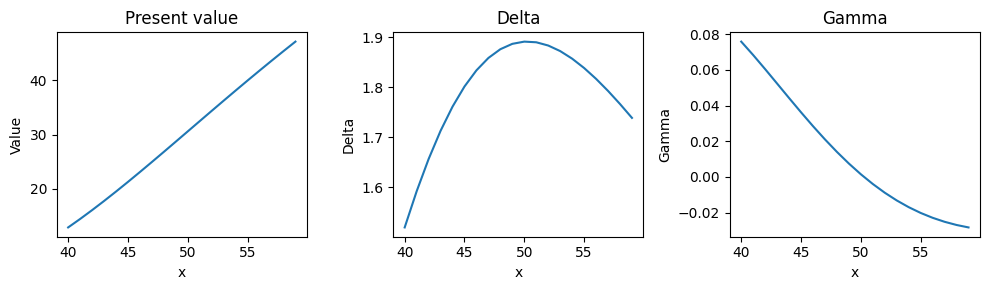

In [3]:
from scipy.stats import norm
import torch
from plotsurfacetool import *
import sympy as sp


class DigitalCallPricer:
    @staticmethod
    def Standard_MC_Digital_torch(s_0, t_0, T, r, sigma, K, N):
        # 0. Settings
        torch.manual_seed(1)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 1. Define variables as PyTorch tensors
        s_0_torch = torch.tensor(s_0, device=device, dtype=torch.float64, requires_grad=True)
        T_torch = torch.tensor(T, device=device, dtype=torch.float64)
        r_torch = torch.tensor(r, device=device, dtype=torch.float64)
        sigma_torch = torch.tensor(sigma, device=device, dtype=torch.float64)
        K_torch = torch.tensor(K, device=device, dtype=torch.float64)
        N_torch = torch.tensor(N, device=device)

        V = torch.full((N_torch,), float('nan'), dtype=torch.float64, device=device)
        s_torch_t0 = s_0_torch.expand(N_torch).clone()
        s_torch = s_0_torch.expand(N_torch).clone()

        # 2. Paths simulation
        dt_torch = T_torch
        z_torch = torch.normal(mean=0, std=1, size=(N_torch,), device=device)
        s_torch_updated = s_torch * torch.exp((r_torch - sigma_torch**2 / 2) * dt_torch + sigma_torch * torch.sqrt(dt_torch) * z_torch)

        # 3. Indicator condition checks
        #V = DigitalCallPricer.digital_indicator(s_torch_updated , K_torch, V)

        V = DigitalCallPricer.digital_indicator_new(s_torch_updated , K_torch, V, s_torch, r_torch, sigma_torch, dt_torch, z_torch, T_torch)
        # 4. Payoff calculation
        # index = torch.isnan(V)
        # V[index] = torch.exp(-r_torch * T_torch) * s_torch_updated[index]
        # V = torch.sum(V[index]) / N_torch

        V = torch.sum(V) / N_torch

        # 5. PyTorch AAD logic
        V.backward()
        value = V.item()
        delta = s_0_torch.grad.item()
        return value, delta

    def digital_indicator(s_torch, K_torch, V):
        index = DigitalCallPricer.smaller_than(s_torch, K_torch) # s_torch < K_torch
        V[index] = 0
        return V

    def smaller_than(input1, input2):
        return input1 < input2

    def digital_indicator_new(s_torch_original, K_torch, V, s_torch, r_torch, sigma_torch, dt_torch, z_torch, T_torch):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Here the first step would be to retrieve the done computations to the 'stochastic node' that would need flagging.
        # Here we use the hard coded version to make clear what needs to be done.

        # Step 1: Create symbolic function with Sympy, corresponding to nodes on an AAD graph
        s0, r, sigma, dt, K = sp.symbols('s0 r sigma dt K')
        # Step 2: Create specific node for random sample, here denoted as z
        z = sp.symbols('z')
        # 'record graph'. In practice, this is already done before, and we'd need to get these computations from s_torch
        s_sympy = s0 * sp.exp((r - sigma**2 / 2) * dt + sigma * sp.sqrt(dt) * z)

        # Now use s_torch < K_torch. Here, we create a computation of
        equation = s_sympy - K

        # Solve the inequality for z symbolically
        z_solution = sp.solve(equation, z)[0]

        z_string = str(z_solution)
        #print(z_string)

        # Replace 'exp' with 'torch.exp', that's just because we use this specific package and still want to use torch
        # This would depend on the used function/AAD framework.
        torch_expr = z_string.replace('exp', 'torch.exp').replace('sqrt', 'torch.sqrt').replace('log', 'torch.log')

        # Define a Torch function from the modified string
        def torch_function(s0, r, sigma, dt, B):
            return eval(torch_expr)

        def price_evaluation(s0, r, sigma, dt, B):
            return s0 * torch.exp((r - sigma**2 / 2) * dt + sigma * torch.sqrt(dt) * torch_function(s0, r, sigma, dt, B))

        u_torch = 0.5 * (1 + torch.erf(z_torch / torch.sqrt(torch.tensor(2.0))))
        two_torch = torch.tensor(2.0, device=device)
        oss_prob = 0.5 * (torch.erf(torch_function(s_torch, r_torch, sigma_torch, dt_torch, K_torch) / torch.sqrt(two_torch)) + 1.0 )
        #oss_prob = 0.5 * (torch.erf((torch.log(K_torch / s_torch) - (r_torch - 0.5 * sigma_torch**2) * dt_torch) / (sigma_torch * torch.sqrt(dt_torch)) / torch.sqrt(two_torch)) + 1.0)

        s_torch_new = s_torch * torch.exp((r_torch- 0.5 * sigma_torch**2) * dt_torch + sigma_torch * torch.sqrt(dt_torch) * torch.erfinv(2 * ((1-oss_prob) * u_torch + oss_prob) - 1) * torch.sqrt(two_torch))

        #Payoff calculation
        V = (1 - oss_prob) * torch.exp(-r_torch * T_torch) * s_torch_new
        return V

# Define constants as class attributes
t_0 = 0.0
T = 1.0
r = 0.04
sigma = 0.3
K = 50
N = 40000

standard_MC_AAD = lambda s_0: DigitalCallPricer.Standard_MC_Digital_torch(s_0, t_0, T, r, sigma, K, N)

plotSettings = PlotSettings()
plotSettings.set_S0Array(np.arange(40.0, 60.0, 1.0))
plotSettings.set_FiniteDifferencesStepWidth(0.0001)
plotSettings.set_OutputStatistic(OutputStatistic.Gamma)

# Closed solution
PlotSurfaceTool.Run(standard_MC_AAD , plotSettings)